# Note from MQ
This is an adaptation of the notebook written by Kenneth Moreland (Website: http://www.kennethmoreland.com/; GitHub: https://github.com/kmorel). It was originally made to generate color maps that have a monotonic increase in luminance. In other words, the brightness increases linearly as you cycle through the hues of your choice. I have kept in most of the notes from Moreland because I found it very helpful to understand the functions as well as thinking about LUTs in the HSV space. Another helpful explanation can be found here: http://www.geeksforgeeks.org/hsv-color-model-in-computer-graphics/ . All notes written by Quintanilla for the adaptation will begin with "MQ:" 

This code relies on the [python-colormath](http://python-colormath.readthedocs.org/en/latest/index.html) module. See [its documentation](http://python-colormath.readthedocs.org/en/latest/index.html) for information such as installation instructions. (It can be installed with either pip or macports.)

In [1]:
from colormath.color_objects import *
from colormath.color_conversions import convert_color

Mostly because it's habit, I am also using [pandas](http://pandas.pydata.org/) dataframes to organize the data. (Pandas can be installed with macports.)

In [2]:
import pandas
import numpy

We will also be using [toyplot](https://toyplot.readthedocs.org) for making visuals (version 0.10.0 or later required). See its documentation for installation instructions.

In [76]:
import toyplot
import toyplot.svg
import skimage.io as io            # This toolbox is what we'll use for reading and writing images 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
 # MQ: line below is to be able to interact with the plots - run this cell twice
%matplotlib notebook 
import matplotlib.pyplot as plt    # This toolbox is to create our plots. Line above makes them interactive

This map is built by spinning through the hues defined in the standard HSV space. Define the start and end hues.

# MQ: Run everything at once after setting the parameters
Cell -> Run All Below

After you run all of the cells below, just look at the resulting color map and example image to check if you need/want to change your parameters (start and end hues, midpoint, brightness cutoff) before naming and saving the LUT. Once you're ready to save, set save_table to true, pick a name, and run all cells below one more time.

# MQ: Define map parameters
LUT_NAME: This is how the lut file will be saved when you run the final cell. This is the last thing that I change after I have run through the notebook and know what colors are in the final map

SAVE_TABLE: Set this to 'True' once you are ready to save the LUT file (once the colors are to your liking and you picked a fun name!)

START_HUE & END_HUE: This map is built by spinning through the hues defined in the standard HSV space. Define the start and end hues.
Here is an HSV color picker that is a good place to start (https://colorpicker.me/#a0729c), but this iteration of the notebook requires some trial and error on hue values.

MIDPOINT: Determines where you switch from decreasing to increasing luminance. It also is where the colors are converted to grayscale for diverging LUTs. In other words, a value of 0 would make a continuous LUT with just increasing luminance the whole time (going from balck, to a color, up to white). Any value about 0 would make a diverging LUT. A value of 0.5 means that the map is linear throughout with the bottom half in grayscale from white to black (and is the default). Another option would be a value of 0.25 if you want to get from white to grey to black quickly and use more space on the map for the color gradient after black

BRIGHTNESS CUTOFF: Defines the maximum brightness. A value of 1.0 gives you white and <1 ends the heatmap where you can still see the end hue

In [175]:
'''Set your color map parameters here. This is kind of home base'''

lut_name = 'MQ_con_emerald'

# save table = True
save_table = False #keep this set to false until you have finalized your parameters and LUT name

start_hue = 134
end_hue = 286

midpoint = 0 # Set to 0 for continuous LUTs and 0.5 (recommended) or 0.25 (I believe this is like a gamma adjustment) for diverging LUTs

brightness_cutoff = 1 # Set to 1 if you want your brightest pixels to be white (not recommended for diverging LUTs)

'''Download my test image or move your image (tif would be easiest) into the folder where this notebook is.
Once the file is in the same folder as the notebook, call the filename in the quotation marks below'''

test_image = io.imread('SUM_20210831_G2A-MEF_Scar-FT_COOLACTIN_Out.tif')


## Support Functions

The original Kindlmann paper created their color map by having a human user adjust the brightness to a prescribed luminance. (The color map was really proposed as a use case for a technique that allows humans to match colors.) Personally, I think this technique is overkill. First of all, no one is going to calibrate to their display. (I don't even want to do it one time just to get initial values.) Second, any change in the display will invalidate the calibration anyway.

Instead, I am going to use a programmatic technique proposed in [a blog post by Matteo Niccoli](https://mycarta.wordpress.com/2012/12/06/the-rainbow-is-deadlong-live-the-rainbow-part-5-cie-lab-linear-l-rainbow/). The idea is to convert the RGB values to the perceptual CIELAB space, adjust the L (luminance) value in CIELAB, and then convert back to RGB.

To do this, we need a function that takes a hue value and adjusts its luminance. Of course, we need to convert to CIELAB and alter the L value. But then we also have to adjust the a and b values so that the color is back in the representable color gamut. We do this with a binary search.

In [176]:
def valid_color(color):
    '''Given a color from the colormath.color_objects package,
    returns whether it can be displayed in RGB.'''
    rgb = convert_color(color, sRGBColor).get_upscaled_value_tuple()
    return ((rgb[0] >= 0) and (rgb[0] <= 255) and
            (rgb[1] >= 0) and (rgb[1] <= 255) and
            (rgb[2] >= 0) and (rgb[2] <= 255))

def safe_color(color):
    '''Given a color from the colormath.color_objects package,
    returns whether it is in the RGB color gamut and far enough
    away from the gamut border to be considered 'safe.' Colors
    right on the edge of displayable colors sometimes do not
    display quite right and also sometimes leave the color
    gamut when interpolated.'''
    rgb_color = convert_color(color, sRGBColor)
    rgb_vector = rgb_color.get_value_tuple()
    clamp_dist = 0.05*(numpy.max(rgb_vector) - numpy.min(rgb_vector))
    return ((rgb_color.rgb_r >= clamp_dist) and (rgb_color.rgb_r <= 1-clamp_dist) and
            (rgb_color.rgb_g >= clamp_dist) and (rgb_color.rgb_g <= 1-clamp_dist) and
            (rgb_color.rgb_b >= clamp_dist) and (rgb_color.rgb_b <= 1-clamp_dist))

def scale_hue(hue, scalar):
    '''Given a hue value (in degrees) and a scalar value between
    0 and 1, create a color to have a luminance proportional to
    the scalar with the given hue. Returns an sRGBColor value.'''
    #Special cases
    if scalar <= 0:
        return sRGBColor(0, 0, 0)
    if scalar >= 1:
        return sRGBColor(1, 1, 1)
    
    # Make hue in the range [0, 360]
    while hue >= 360:
        hue -= 360
    while hue < 0:
        hue += 360

    hsv_original = HSVColor(hue, 1.0, 1.0)
    rgb_original = convert_color(hsv_original, sRGBColor)
    lab_original = convert_color(rgb_original, LabColor)
    l_target = 100.0*scalar
    a_original = lab_original.lab_a
    b_original = lab_original.lab_b
    observer = lab_original.observer
    illuminant = lab_original.illuminant
    
    high_scale = 1.0
    low_scale = 0.0
    for i in range(0, 12):
        mid_scale = (high_scale-low_scale)/2 + low_scale
        if safe_color(LabColor(l_target, mid_scale*a_original, mid_scale*b_original,
                               observer=observer, illuminant=illuminant)):
            low_scale = mid_scale
        else:
            high_scale = mid_scale
            
    return convert_color(LabColor(l_target, low_scale*a_original, low_scale*b_original,
                                  observer=observer, illuminant=illuminant),
                         sRGBColor)

In [177]:
def grayscale(rgb):
    '''In order to just keep the table'''
    value = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    return (value, value, value)

A function that takes an array of hues and builds a table (in a pandas dataframe) of colors adjusted for luminance.

In [178]:
def build_colors(hue_array, scalar_array):
    table = pandas.DataFrame()
    table['hue'] = hue_array
    table['scalar'] = scalar_array #numpy.linspace(0.0, 1.0, table['hue'].size)
    # Use the scale_hue function on each row to get the color we
    # should use at each point.
    color_array = table.apply(lambda row: scale_hue(row['hue'], row['scalar']),
                              axis=1)
    table['sRGBColor'] = color_array
    table['RGB'] = color_array.apply(lambda rgb: rgb.get_upscaled_value_tuple())
    table['sRGB'] = color_array.apply(lambda rgb: rgb.get_value_tuple())
    return table

In [179]:
'''MQ: This is the adaptation the allows for either continuous or diverging LUTs depending on the parameters set.'''

def build_diverge_colors(hue_array, midpoint, brightness_cutoff):
    left = int(midpoint * hue_array.size)
    right = hue_array.size - left
    scalar_array = numpy.concatenate([
        numpy.linspace(1.0, 0.0, left),
        numpy.linspace(0.0, brightness_cutoff, right) 
    ])
    return build_colors(hue_array, scalar_array)


A convenience function that takes a column of RGB triples in a pandas dataframe, unzips it, and adds three columns to the data frame with the red, green, and blue values.

In [180]:
def unzip_rgb_triple(dataframe, column='RGB'):
    '''Given a dataframe and the name of a column holding an RGB triplet,
    this function creates new separate columns for the R, G, and B values
    with the same name as the original with '_r', '_g', and '_b' appended.'''
    # Creates a data frame with separate columns for the triples in the given column
    unzipped_rgb = pandas.DataFrame(dataframe[column].values.tolist(),
                                    columns=['r', 'g', 'b'])
    # Add the columns to the original data frame
    dataframe[column + '_r'] = unzipped_rgb['r']
    dataframe[column + '_g'] = unzipped_rgb['g']
    dataframe[column + '_b'] = unzipped_rgb['b']

In [181]:
def grayscale_convert(table):
    grays_palette = table['sRGB'].apply(grayscale).values
    rgb_palette = table['sRGB'].values
    slice_index = int(len(grays_palette)*midpoint)
    input_array = numpy.concatenate([grays_palette[:slice_index], rgb_palette[slice_index:]])
    colors_palette = toyplot.color.Palette(colors=input_array)

    return colors_palette

## Create Color Map

We start by creating a "short" map with a minimal amount of control points. These control points are placed where the RGB interpolation bends and then midway between these bends to round out the hue spin. This amounts to every 30 degrees in HSV space. Create a table starting with the scalar values and the hue angle for each one.

In [182]:
control_points = build_diverge_colors(
    numpy.linspace(start_hue, end_hue, 8),
    midpoint,
    brightness_cutoff
)
control_points

,hue,scalar,sRGBColor,RGB,sRGB
0,134.000000,0.000000,sRGBColor (rgb_r:0.0000 rgb_g:0.0000 rgb_b:0.0...,"(0, 0, 0)","(0.0, 0.0, 0.0)"
1,155.714286,0.128571,sRGBColor (rgb_r:0.0074 rgb_g:0.1546 rgb_b:0.0...,"(2, 39, 20)","(0.007378552885304203, 0.1545553963001353, 0.0..."
2,177.428571,0.257143,sRGBColor (rgb_r:0.0131 rgb_g:0.2701 rgb_b:0.2...,"(3, 69, 66)","(0.013119174771110808, 0.2701010223715406, 0.2..."
3,199.142857,0.385714,sRGBColor (rgb_r:0.0272 rgb_g:0.3768 rgb_b:0.5...,"(7, 96, 143)","(0.027159709947033175, 0.37682251838170605, 0...."
4,220.857143,0.514286,sRGBColor (rgb_r:0.3860 rgb_g:0.4150 rgb_b:0.9...,"(98, 106, 248)","(0.3859526602824788, 0.4150391804357072, 0.970..."
5,242.571429,0.642857,sRGBColor (rgb_r:0.6806 rgb_g:0.5297 rgb_b:0.9...,"(174, 135, 249)","(0.6806405226291444, 0.5297147445804087, 0.977..."
6,264.285714,0.771429,sRGBColor (rgb_r:0.8295 rgb_g:0.6884 rgb_b:0.9...,"(212, 176, 251)","(0.8294835504411627, 0.6883504501103271, 0.985..."
7,286.000000,0.900000,sRGBColor (rgb_r:0.9643 rgb_g:0.8510 rgb_b:0.9...,"(246, 217, 253)","(0.9643083021748341, 0.8509694843176385, 0.992..."


Now repeat creating this table but for a much higher resolution.

In [183]:
colors_long = build_diverge_colors(
    numpy.linspace(start_hue, end_hue, 1024),
    midpoint,
    brightness_cutoff
)

## Plot the Color Map.

In [184]:
colors_palette = grayscale_convert(colors_long)
colors_map = toyplot.color.LinearMap(palette=colors_palette,
                                     domain_min=0, domain_max=1)

In [185]:
table_length = 256
color_table = build_diverge_colors(
    numpy.linspace(start_hue, end_hue, num=table_length),
    midpoint,
    brightness_cutoff)

unzip_rgb_triple(color_table, 'RGB')

In [186]:
'''MQ: Formats a list of RGB values suitable for a FIJI LUT file.'''

color_list = []
for i in range(table_length):
    
    color = (color_table['sRGB'][i][0], color_table['sRGB'][i][1], color_table['sRGB'][i][2])
    
    if (i < midpoint * table_length):
        color = ((255-(i* (1/midpoint)))/256,(255-(i* (1/midpoint)))/256,(255-(i* (1/midpoint)))/256)
    color_list.append(color)

<IPython.core.display.Javascript object>


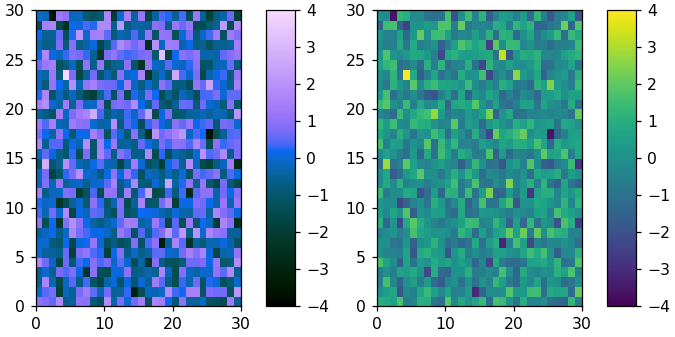

In [187]:
'''MQ: Plots random data using new colormap and compares it to a known classic, viridis'''

newcmp = ListedColormap(color_list)
viridis = cm.get_cmap('viridis', 256)
def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    numpy.random.seed(19680801)
    data = numpy.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

plot_examples([newcmp, viridis])

<IPython.core.display.Javascript object>


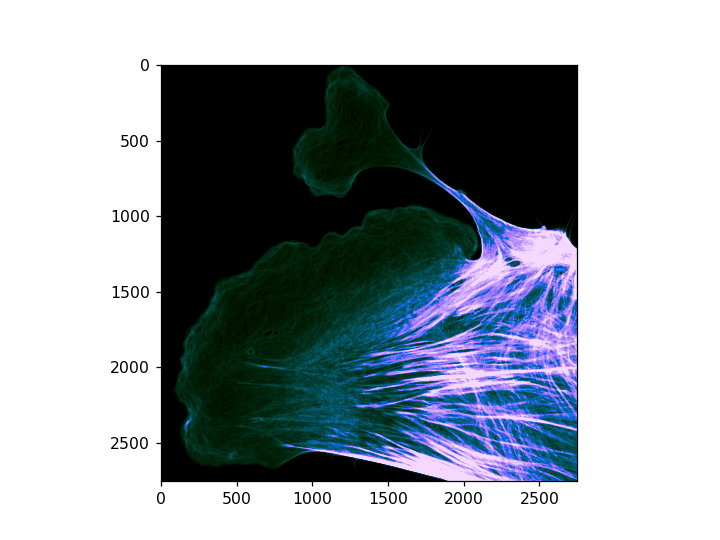

In [190]:
'''MQ: Download my test image or move your image (tif would be easiest) into the folder where this notebook is.
Once the file is in the same folder as the notebook, call the filename in the quotation marks below'''

fig, axes = plt.subplots()
axes.imshow(test_image, cmap=newcmp, vmin=50, vmax=90000) #adjust brightness min and max values as needed
fig.show()

In [189]:
'''This will run and save the LUT file and an SVG of the LUT scale bar once you finalize the parameters,
choose and define the LUT name, and set save_table to True'''

if save_table == True:
    with open('{}_{}.lut'.format(lut_name, table_length), 'w') as file:
        file.write('Index Red Green Blue\n')
        for i in range(table_length):
            color = (color_table['RGB_r'][i], color_table['RGB_g'][i], color_table['RGB_b'][i])
            if (i < midpoint * table_length):
                color = (255-(i* (1/midpoint)),255-(i* (1/midpoint)),255-(i* (1/midpoint)))
            file.write('{} {} {} {}\n'.format(i, int(color[0]), int(color[1]), int(color[2])))

     #Saves the lut scale bar
    toyplot.svg.render(canvas, '{}.svg'.format(lut_name))